In [13]:
import baltic as bt
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap, to_hex
from matplotlib.patches import FancyArrowPatch


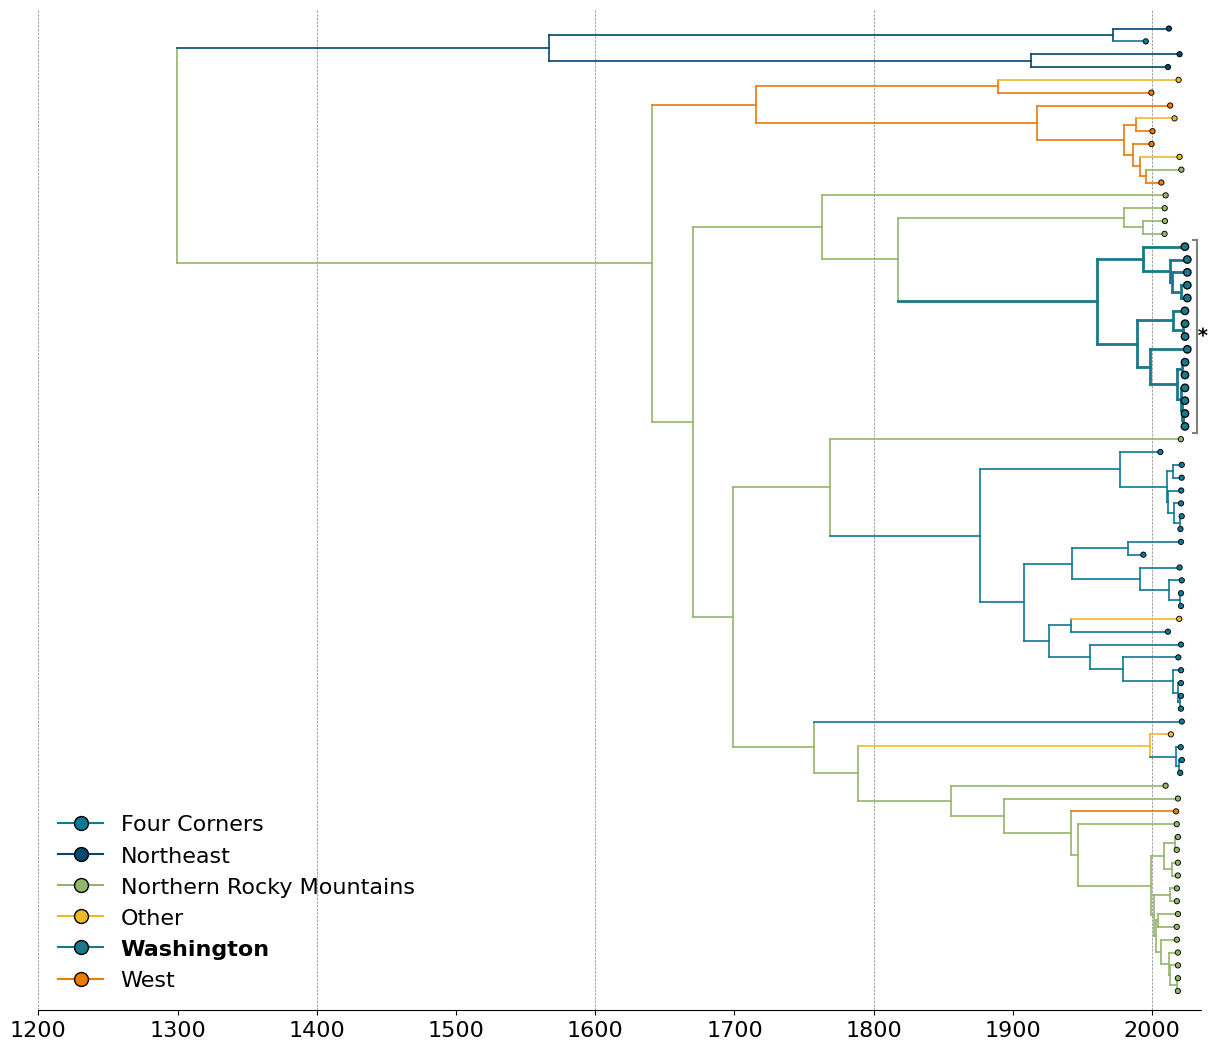

In [14]:
ll = bt.loadNewick('../Trees/phylogeography/ncbi_whitman_aligned.annotated.tree', absoluteTime=False)
ll.sortBranches(descending=True)

ll.setAbsoluteTime(2025.25)

#Functions
# Function to plot a curved arrow pointing to a node
def plot_curved_arrow(ax, start_x, start_y, end_x, end_y):
    arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y), 
                            connectionstyle="arc3,rad=-0.3",  # Creates a curve
                            color='black', 
                            arrowstyle='->,head_length=10,head_width=4', lw=2, zorder = 1000)
    ax.add_patch(arrow)

def introductions_into_WA(k):
    return 'State' in k.traits and k.traits['State'] == 'WA'

#Optional 
state_to_region = {
    'CO': 'Four Corners',
    'NM': 'Four Corners',
    'AZ': 'Four Corners',
    'MT': 'Northern Rocky Mountains',
    'WY': 'Northern Rocky Mountains',
    'CA': 'West',
    'NY': 'Eastern United States',
    'ME': 'Eastern United States'
}

def group_states(tree):
    for node in tree.Objects:
        if not node.traits or 'State' not in node.traits:
            continue
        state = node.traits['State']
        if state in ['USA', 'WA']:
            continue  # keep these as is
        node.traits['State'] = state_to_region.get(state, state)  # default: unchanged

group_states(ll)

# Extract states after grouping
states = []
for node in ll.Objects:
    if 'State' in node.traits:
        states.append(node.traits['State'])

state_list = sorted(set(states))

# Use your fixed palette
base_colors = ['#00496f', '#0f85a0', '#edd746', '#ed8b00', '#dd4124']
custom_cmap = LinearSegmentedColormap.from_list("custom_palette", base_colors, N=max(1, len(state_list)))
palette_colors = [to_hex(custom_cmap(i / max(1, len(state_list) - 1))) for i in range(len(state_list))]

# Fix WA color
fixed_colors = {'WA': '#19798b'}

# Remove WA from assignment pool
dynamic_regions = [s for s in state_list if s not in fixed_colors]

# Assign remaining colors from base palette
dynamic_color_map = dict(zip(dynamic_regions, palette_colors[:len(dynamic_regions)]))

# Merge
state_color_map = {**dynamic_color_map, **fixed_colors}
ll.cmap = {'state': state_color_map}

# Color function
def c_func(node):
    return ll.cmap['state'].get(node.traits['State'], 'lightgrey')


remaining_states = [s for s in state_list if s not in fixed_colors]


remaining_color_map = {
    state: palette_colors[i]
    for i, state in enumerate(remaining_states)
}


# Combine into final state color map
state_color_map = {**remaining_color_map, **fixed_colors}

ll.cmap = {} 
ll.cmap['state'] = state_color_map


def c_func(node):
    state = node.traits['State']
    if state == "WA": 
        return '#19798b'
    else:
        return ll.cmap['state'].get(state, 'lightgrey')



fig, ax = plt.subplots(figsize=(15,13), facecolor='w')
ll.plotTree(
    ax,
    colour=c_func,
    width=lambda n: 2 if n.traits['State'] == 'WA' else 1.2,
    x_attr=lambda n: n.absoluteTime,
    y_attr=lambda n: n.y
)

ll.plotPoints(
    ax,
    colour=c_func,
    x_attr=lambda n: n.absoluteTime,
    y_attr=lambda n: n.y,
    size=lambda n: 20 if n.traits['State'] == 'WA' else 10,
    zorder=20002
)

#add bracket to highlight our samples
wa_nodes = [n for n in ll.Objects if n.is_leaf() and n.traits.get('State') == 'WA']
y_coords = [n.y for n in wa_nodes]

ymin = min(y_coords) - 0.5
ymax = max(y_coords) + 0.5

x_bracket =2032
plt.plot([x_bracket, x_bracket], [ymin, ymax], color='grey', linewidth=1.5)
cap_len = 3
plt.plot([x_bracket - cap_len, x_bracket], [ymin, ymin], color='grey', linewidth=1.5)
plt.plot([x_bracket - cap_len, x_bracket], [ymax, ymax], color='grey', linewidth=1.5)
plt.text(x_bracket + 0.8, (ymin + ymax) / 2, '*', fontsize=14, va='center', fontweight='bold', path_effects=[path_effects.Normal()])

introduction_dates = []

# for node in ll.Objects:
#     if introductions_into_WA(node) and node.parent and node.parent.traits['State'] != 'WA':
#         # Get coordinates for arrow start and end
#         end_x, end_y = get_parent_coordinates(node)
#         start_x, start_y = other_coordinate(node)
#         start_x = start_x - 50
#         start_y = start_y 
        
#         # Plot curved arrow
#         plot_curved_arrow(ax, start_x, start_y, end_x, end_y)
        
#         # Annotate the time of introduction (absoluteTime) next to the arrow
#         introduction_time = decimal_year_to_date(round(node.parent.absoluteTime, 2))
#         introduction_time = introduction_time.strftime('%Y-%m-%d')
#         introduction_dates.append(introduction_time)
#         ax.text(start_x - 0.8, start_y - 2, f'{introduction_time}', fontsize=16, color='black', ha='center', zorder = 1001)

#custom legend
# legend_dict = {'AZ':'Arizona','CA': 'California', 'CO':'Colorado', 'ME':'Maine', 'MT':'Montana', 'NM':'New Mexico', 'NY': 'New York', 'USA':'Other',
#                'WA':'Washington', 'WY':'Wyoming'}
legend_dict = {
    'Four Corners': 'Four Corners',
    'Northern Rocky Mountains': 'Northern Rocky Mountains',
    'West': 'West',
    'Eastern United States': 'Northeast',
    'USA': 'Other',
    'WA': 'Washington'
}

legend_elements = []
for state in state_list:
    legend_elements.append(
        plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='-',      
            color=ll.cmap['state'][state],  
            markerfacecolor=ll.cmap['state'][state], 
            markeredgecolor='black', 
            label=legend_dict.get(state, state),
            markersize=10
        )
    )


#sort legend elements
legend_elements = sorted(legend_elements, key=lambda x: x.get_label())

leg = plt.legend(
    handles=legend_elements,
    loc='lower left',
    frameon=False,
    fontsize=16,
    labelcolor='black'
)

for text in leg.get_texts():
    if text.get_text() == 'Washington':
        text.set_weight('bold')

for loc in ['top','right','left']:
    ax.spines[loc].set_visible(False)
ax.set_yticklabels([])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
[ax.axvline(t,ls='--',lw=0.5,color='grey', zorder= -1) for t in range(600,2025,200)]
ax.set_xlim(1200,  2035)
ax.set_ylim(-1, ll.ySpan + 1)


#plt.savefig('ncbi_whitman_phylogeography_final.png', dpi=1200, bbox_inches='tight')
#plt.savefig('ncbi_whitman_phylogeography_final.svg', dpi=1200, bbox_inches='tight')
plt.show()

subtree resulting from MT>WA switch, traversing within WA


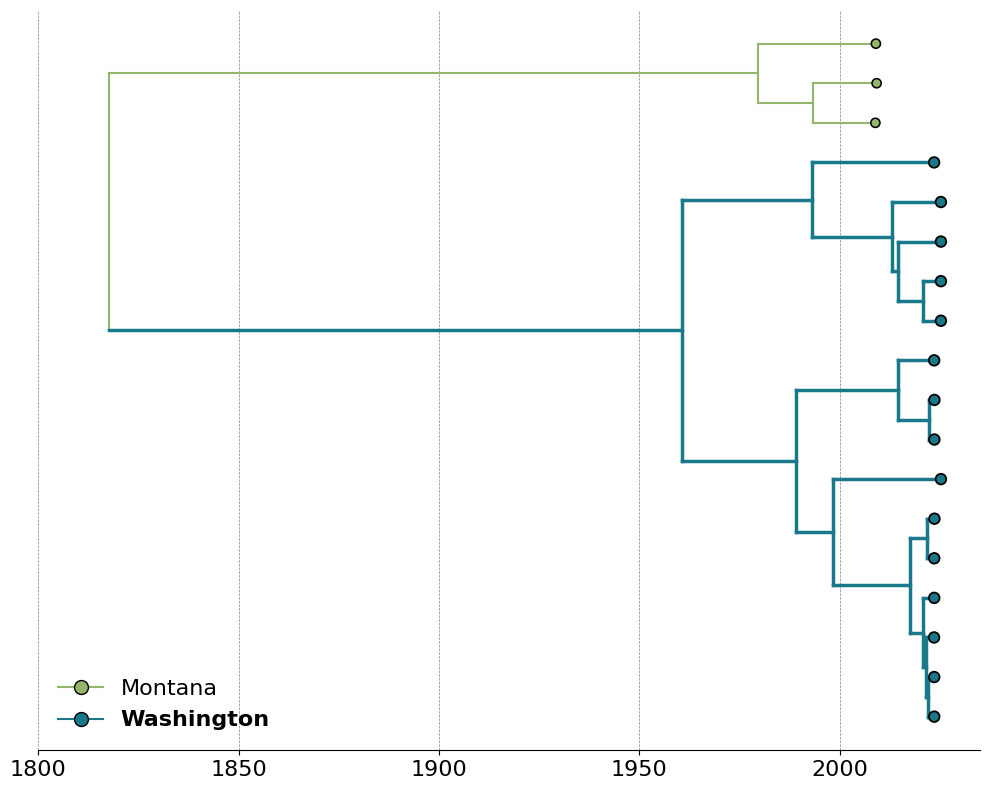

In [15]:
traitName = 'State'
llWa = None  # initialize

for node in ll.Objects:
    if not node.parent:  # skip root
        continue

    child_state = node.traits.get(traitName)
    parent_state = node.parent.traits.get(traitName, 'ancestor')

    if parent_state == 'Northern Rocky Mountains' and child_state == 'WA':
        print(f'subtree resulting from MT>WA switch, traversing within WA')
        traverse_condition = lambda n: n.traits.get(traitName) in ['WA', 'Northern Rocky Mountains']
        subtree = ll.subtree(node.parent, traverse_condition=traverse_condition, stem=False)

        if subtree:
            subtree.traverse_tree()
            subtree.sortBranches()
            llWa = subtree
        break  # stop after the first match

fig, ax = plt.subplots(figsize=(10, 8), facecolor='w')

if llWa:
    llWa.plotTree(
        ax,
        colour=c_func,
        width=lambda n: 2.5 if n.traits['State'] == 'WA' else 1.5,
        x_attr=lambda n: n.absoluteTime,
        y_attr=lambda n: n.y
    )

    llWa.plotPoints(
        ax,
        colour=c_func,
        x_attr=lambda n: n.absoluteTime,
        y_attr=lambda n: n.y,
        size=lambda n: 40 if n.traits['State'] == 'WA' else 30,
        zorder=20002
    )
else:
    print("No MT > WA transition subtree found.")

#custom legend
legend_dict = {
    'Four Corners': 'Four Corners',
    'Northern Rocky Mountains': 'Montana',
    'West': 'West',
    'Eastern United States': 'Northeast',
    'USA': 'Other',
    'WA': 'Washington'
}
legend_elements = []
state_list = ['Northern Rocky Mountains','WA']
for state in state_list:
    legend_elements.append(
        plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='-',      
            color=ll.cmap['state'][state],  
            markerfacecolor=ll.cmap['state'][state], 
            markeredgecolor='black', 
            label=legend_dict.get(state, state),
            markersize=10
        )
    )


#sort legend elements
legend_elements = sorted(legend_elements, key=lambda x: x.get_label())

leg = plt.legend(
    handles=legend_elements,
    loc='lower left',
    frameon=False,
    fontsize=16,
    labelcolor='black'
)

for text in leg.get_texts():
    if text.get_text() == 'Washington':
        text.set_weight('bold')


for loc in ['top','right','left']:
    ax.spines[loc].set_visible(False)
ax.set_yticklabels([])
ax.tick_params(axis='x', labelsize=16)
#Remove Y tick markers
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
[ax.axvline(t,ls='--',lw=0.5,color='grey', zorder= -1) for t in range(1800,2025,50)]
ax.set_xlim(1800,  2035)


plt.tight_layout()
#plt.savefig('wa_introduction_phylogeography.png', dpi=1200, bbox_inches='tight')
plt.show()

In [16]:
#Map
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from metpy.cbook import get_test_data

In [17]:
#State coordinates
state_coords = {
    'WA': (-121.490494, 47.400902),
    'MT': (-110.454353, 46.921925),
    'CA': (-119.681564, 36.116203),
    'NM': (-106.248482, 34.840515),
    'AZ': (-111.431221, 33.729759),
    'Other': (-98.583333, 39.833333),
}

#Create a dataframe
df = pd.DataFrame(state_coords).T.reset_index()
df.columns = ['State', 'Longitude', 'Latitude']
#swap the order of columns
df = df[['State', 'Latitude', 'Longitude']]

#save without column names
df.to_csv('state_coordinates.txt', sep='\t', index=False, header=False)

In [18]:
#Load Bayes Factor
bayes_factor = pd.read_csv('../Trees/phylogeography/bayes-data_SNV.csv', sep=',')

bayes_factor.head()

,from,to,bayes-factor,posterior-probability
0,WA,MT,0.955793,0.103433
1,WA,CA,1.158230,0.122653
2,WA,CO,0.982205,0.105988
3,WA,NM,1.111823,0.118320
4,WA,AZ,2.202008,0.209977


In [20]:
import pandas as pd
log = pd.read_csv("../Trees/phylogeography/ncbi_whitman_aligned.State.rates.log", sep="\t", comment="#")
rates = log.filter(like="rate", axis=1)
presence = log.filter(like="indicator", axis=1)

In [23]:
"""
COUNT SOURCE STATES OF WA INTRODUCTIONS
"""

from pathlib import Path
import re, baltic as bt, pandas as pd
from collections import Counter, defaultdict

# ── USER OPTIONS ──────────────────────────────────────────────────────────────
TREES_FILE   = Path("../Trees/phylogeography/ncbi_whitman_aligned.trees")
BURNIN_FRAC  = 0.10            
TRAIT, TARGET = "State", "WA"

STATE_TO_REGION = {
    'CO':'Four Corners','NM':'Four Corners','AZ':'Four Corners',
    'MT':'Montana','WY':'Northern Rocky Mtns',
    'CA':'West','NY':'Eastern U.S.','ME':'Eastern U.S.'
}

# ── HELPERS ───────────────────────────────────────────────────────────────────
tx_line   = re.compile(r"^\s*([0-9]+)\s+([^,;]+)")
tree_head = re.compile(r"^\s*tree\s+")

def parse_translate(lines):
    """Return {num:str} once the Translate block (in Begin trees) is found."""
    trans, inside = {}, False
    for ln in lines:
        if ln.strip().lower().startswith("translate"):
            inside = True
            continue
        if inside:
            if ";" in ln:               # end of block
                break
            m = tx_line.match(ln)
            if m:
                trans[m.group(1)] = m.group(2).strip("\"'")
    return trans

def iter_posterior(path: Path, burnin: float = 0.1):
    """
    Yield post-burn-in baltic Tree objects from a BEAST .trees file
    (no dependence on readNexus / loadNexus).
    """
    with path.open() as fh:
        raw = fh.readlines()

    tip_map = parse_translate(raw)
    tree_strings = []
    buf, collecting = "", False

    for ln in raw:
        if tree_head.match(ln):                    
            buf = ln.split("=", 1)[1].lstrip()      # keep part after '='
            collecting = ";" not in buf             
            if not collecting:
                tree_strings.append(buf[buf.index("("):buf.index(";")+1])
        elif collecting:
            buf += ln.strip()
            if ";" in ln:
                collecting = False
                tree_strings.append(buf[buf.index("("):buf.index(";")+1])

    assert tree_strings, "No tree strings found – check file structure."

    start = int(len(tree_strings) * burnin)
    for s in tree_strings[start:]:
        t = bt.make_tree(s)
        t.traverse_tree();  t.sortBranches()
        if tip_map:
            t.renameTips(tip_map)
        yield t

def pool_states(t):
    for n in t.Objects:
        st = n.traits.get(TRAIT)
        if not st or st in (TARGET, 'USA'):
            continue
        n.traits[TRAIT] = STATE_TO_REGION.get(st, st)

def count_intros(t):
    c = Counter()
    for n in t.Objects:
        if n.parent:
            child, par = n.traits.get(TRAIT), n.parent.traits.get(TRAIT)
            if child == TARGET and par and par != TARGET:
                c[par] += 1
    return c

# ── MAIN ──────────────────────────────────────────────────────────────────────
overall = Counter()
per_tree = defaultdict(Counter)

for k, tr in enumerate(iter_posterior(TREES_FILE, BURNIN_FRAC), 1):
    pool_states(tr)
    counts = count_intros(tr)
    overall.update(counts)
    per_tree[k] = counts        

total = sum(overall.values())
summary = (pd.DataFrame.from_dict(overall, orient="index",
                                  columns=["n_introductions"])
             .assign(posterior_freq=lambda d: 100*d.n_introductions/total)
             .sort_values("n_introductions", ascending=False))

print("\n════════════════════ WA INTRODUCTIONS BY SOURCE ═══════════════════")
print(summary.to_string(formatters={"posterior_freq": "{:.2f}%".format}))
print(f"\nTotal independent introductions detected: {total}")


════════════════════ WA INTRODUCTIONS BY SOURCE ═══════════════════
                     n_introductions posterior_freq
Montana                         8364         89.50%
Four Corners                     380          4.07%
West                             237          2.54%
USA                              155          1.66%
Northern Rocky Mtns              119          1.27%
Eastern U.S.                      90          0.96%

Total independent introductions detected: 9345


In [24]:
#!/usr/bin/env python
"""
COUNT ALL STATE-TO-STATE TRANSITIONS IN A BEAST POSTERIOR
(no state grouping, no WA filter)
"""

from pathlib import Path
import re, baltic as bt, pandas as pd
from collections import Counter, defaultdict

# ── USER OPTIONS ─────────────────────────────────────────────────────────────
TREES_FILE  = Path("../Trees/phylogeography/ncbi_whitman_aligned.trees")
BURNIN_FRAC = 0.10
TRAIT       = "State"

# ── REGEX HELPERS (same as before) ───────────────────────────────────────────
_tx_line   = re.compile(r"^\s*([0-9]+)\s+([^,;]+)")
_tree_head = re.compile(r"^\s*tree\s+", re.IGNORECASE)

def parse_translate(lines):
    trans, inside = {}, False
    for ln in lines:
        if ln.strip().lower().startswith("translate"):
            inside = True
            continue
        if inside:
            if ";" in ln:
                break
            m = _tx_line.match(ln)
            if m:
                trans[m.group(1)] = m.group(2).strip("\"'")
    return trans

def iter_posterior(path: Path, burnin: float = 0.1):
    with path.open() as fh:
        raw = fh.readlines()

    tip_map = parse_translate(raw)
    tree_strings, buf, collecting = [], "", False

    for ln in raw:
        if _tree_head.match(ln):
            buf = ln.split("=", 1)[1].lstrip()
            collecting = ";" not in buf
            if not collecting:
                tree_strings.append(buf[buf.index("("):buf.index(";")+1])
        elif collecting:
            buf += ln.strip()
            if ";" in ln:
                collecting = False
                tree_strings.append(buf[buf.index("("):buf.index(";")+1])

    if not tree_strings:
        raise ValueError("No tree strings found.")

    start = int(len(tree_strings) * burnin)
    for s in tree_strings[start:]:
        t = bt.make_tree(s)
        t.traverse_tree()
        t.sortBranches()
        if tip_map:
            t.renameTips(tip_map)
        yield t

# ── NEW STATISTIC ────────────────────────────────────────────────────────────
def count_transitions(tree) -> Counter:
    """
    Return Counter keyed by (parent_state, child_state) for every edge
    where states differ.
    """
    C = Counter()
    for n in tree.Objects:
        if not n.parent:
            continue
        parent_state = n.parent.traits.get(TRAIT)
        child_state  = n.traits.get(TRAIT)
        if parent_state and child_state and parent_state != child_state:
            C[(parent_state, child_state)] += 1
    return C

# ── MAIN LOOP ────────────────────────────────────────────────────────────────
overall = Counter()
per_tree = defaultdict(Counter)

for idx, tr in enumerate(iter_posterior(TREES_FILE, BURNIN_FRAC), 1):
    counts = count_transitions(tr)
    overall.update(counts)
    per_tree[idx] = counts

# ── TABULATE AS MATRIX ───────────────────────────────────────────────────────
if not overall:
    raise RuntimeError("No state transitions detected.")

# all unique states encountered
states = sorted({s for pair in overall.keys() for s in pair})

# DataFrame with zeros then fill counts
mat = pd.DataFrame(0, index=states, columns=states, dtype=int)
for (src, dst), n in overall.items():
    mat.loc[src, dst] += n

# OPTIONAL: convert to percentages of total transitions
mat = 100 * mat / mat.values.sum()

print("\n════════════ STATE-TO-STATE TRANSITION COUNTS ════════════")
print(mat.to_string())
print(f"\nTotal transitions counted (posterior, post-burn-in): {mat.values.sum()}")


════════════ STATE-TO-STATE TRANSITION COUNTS ════════════
           AZ         CA        CO        ME        MT        NM        NY        USA        WA        WY
AZ   0.000000   0.069213  0.158344  0.045810  0.174278  0.709559  0.142908   0.656280  0.025893  0.099587
CA   0.587067   0.000000  0.538767  0.094608  1.364345  0.637358  0.207141  14.469026  0.118011  5.844773
CO   0.691633   0.236520  0.000000  0.063238  0.473537  2.684871  0.215606   1.943942  0.065230  0.200170
ME   0.013444   0.139422  0.023901  0.000000  0.551215  0.219092  2.662464   0.009959  0.013942  0.011950
MT   0.793212  11.313605  3.865976  0.308720  0.000000  1.682526  0.517356   3.545803  4.164737  1.865268
NM   1.994234   0.485488  6.499559  0.192203  1.003839  0.000000  2.543955   2.200379  0.098093  0.553207
NY   0.026889   0.193697  0.054773  2.864128  0.626901  3.078241  0.000000   0.025395  0.030872  0.030872
USA  4.844420   0.244487  1.664102  0.084649  0.635366  2.477730  0.253947   0.000000  0.077

In [25]:
pct = mat
pct = pct.where(pct >= 1.0, other=0.0)

# 3) convert to tidy dataframe, keep only non-zero transitions
tidy = (
    pct.stack()                 # wide → long; produces MultiIndex (src, dst)
       .reset_index()           # columns: "level_0", "level_1", 0
       .rename(columns={"level_0": "source",
                        "level_1": "destination",
                        0: "percent"})
       .query("percent > 0")    # drop rows that were masked to 0
       .sort_values("percent", ascending=False)
       .reset_index(drop=True)
)

print("\n════════════ TRANSITIONS ≥ 1 % OF POSTERIOR ═════════════")
print(tidy)

# If you still need raw counts alongside:
tidy["count"] = tidy.apply(lambda r: mat.loc[r.source, r.destination], axis=1)



════════════ TRANSITIONS ≥ 1 % OF POSTERIOR ═════════════
   source destination    percent
0      CA         USA  14.469026
1      MT          CA  11.313605
2      NM          CO   6.499559
3      CA          WY   5.844773
4     USA          AZ   4.844420
5      MT          WA   4.164737
6      MT          CO   3.865976
7      MT         USA   3.545803
8      NY          NM   3.078241
9      NY          ME   2.864128
10     CO          NM   2.684871
11     ME          NY   2.662464
12     NM          NY   2.543955
13    USA          NM   2.477730
14     NM         USA   2.200379
15     NM          AZ   1.994234
16     CO         USA   1.943942
17     MT          WY   1.865268
18     MT          NM   1.682526
19    USA          CO   1.664102
20     CA          MT   1.364345
21     NM          MT   1.003839


/var/folders/8v/6y3r5h_x0dv5t5875drggrtc0000gn/T/ipykernel_4455/3721974124.py:85: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  state_centroids = us.set_index('STUSPS').geometry.centroid


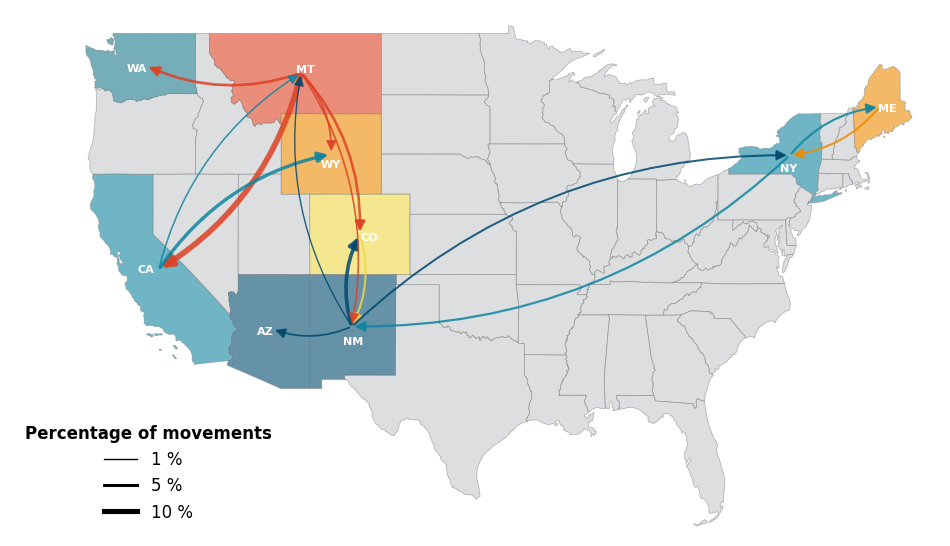

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines   import Line2D
import numpy as np

# ── 1.  READ SHAPEFILE + COLORS  ────────────────────────────────────────────
us = gpd.read_file('../Scripts/Maps/cb_2022_us_state_20m.shp')


# ── BUILD A COMPLETE colour map  ────────────────────────────────────────────
import matplotlib.colors as mcolors

# 1) gather every state code that appears in the tidy transitions table
states_in_data = sorted(set(tidy['source']).union(tidy['destination']))

# 2) reserve WA, everyone else goes into the palette cycle
base_colors = ['#00496f', '#0f85a0', '#edd746', '#ed8b00', '#dd4124']
states_no_wa = [s for s in states_in_data if s != 'WA']

# repeat base palette as many times as needed
palette_cycle = (base_colors * ((len(states_no_wa) // len(base_colors)) + 1))[:len(states_no_wa)]

state_color_map = {s: col for s, col in zip(states_no_wa, palette_cycle)}
state_color_map['WA'] = '#19798b'      # fixed WA colour

# 3) optional – light-grey fallback for states not observed
default_colour = '#c6c8ca'
us['fill_color'] = us['STUSPS'].map(state_color_map).fillna('#c6c8ca')
# ── 2.  BASE MAP  ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 10))

us.plot(ax=ax, edgecolor='gray', color=us['fill_color'],
        linewidth=0.5, alpha=0.6)

#label offset
def label_offset(abbr):
    """
    Return (dx, dy) degrees to nudge the text label for a given state.

    negative dx  → left   shift
    positive dx  → right  shift
    positive dy  → up     shift
    negative dy  → down   shift
    """
    if abbr in {"WA", "CA", "AZ"}:
        return (-0.5, 0)        # left
    if abbr == "MT":
        return (0, 0.5)         # up
    if abbr in {"ME"}:
        return (0.5, 0)         # right
    if abbr in {"CO"}:
        return (0.65, 0)
    if abbr in {'NY'}:
        return (0.5, -0.5)
    # default: move down
    return (0, -0.5)

label_points = us.representative_point()
for idx, row in us.iterrows():
    abbr = row['STUSPS']
    if abbr in state_color_map:
        pt = label_points.iloc[idx]
        dx, dy = label_offset(abbr)
        ax.text(pt.x + dx, pt.y + dy,
                        abbr,
                        fontsize=8,
                        ha='center',
                        va='center',
                        color='white',         # all labels white
                        weight='bold')

ax.set_xlim(-130, -65);  ax.set_ylim(24, 50.2)
ax.axis('off')

# ── 3.  SCALE FUNCTION (width ∝ percent)  ───────────────────────────────────
pct_min = tidy['percent'].min()
pct_max = tidy['percent'].max()

def scale_width(pct):
    """1 ≤ width ≤ 5   (linear in percent)."""
    return 1 + 4 * (pct - pct_min) / (pct_max - pct_min)

# ── 4.  STATE CENTROIDS  ─────────────────────────────────────────────────────
state_centroids = us.set_index('STUSPS').geometry.centroid

# ── 5.  DRAW ARROWS  ────────────────────────────────────────────────────────
for _, row in tidy.iterrows():
    src, dst, pct = row['source'], row['destination'], row['percent']

    if src not in state_centroids.index or dst not in state_centroids.index:
        continue

    start, end = state_centroids[src], state_centroids[dst]

    arrow = FancyArrowPatch(
        (start.x, start.y), (end.x, end.y),
        connectionstyle="arc3,rad=-0.2",
        arrowstyle='-|>',
        color=state_color_map.get(src, 'black'),
        linewidth=scale_width(pct),
        alpha=0.85,
        mutation_scale=15
    )
    ax.add_patch(arrow)

# ── 6.  LEGEND  (Percentage of movements)  ──────────────────────────────────
legend_ticks = [1, 5, 10]            # % thresholds you want to show

legend_elements = [
    Line2D([0], [0],
           color='black',
           lw=scale_width(p),
           label=f'{p} %' )
    for p in legend_ticks
]

leg = ax.legend(handles=legend_elements,
                loc='lower left',
                frameon=False,
                fontsize='large',
                labelspacing=0.5,
                title='Percentage of movements',
                title_fontsize='large')

leg.get_title().set_weight('bold')

plt.savefig('state_transitions_map_percent.jpeg',
            dpi=1200, bbox_inches='tight')
plt.savefig('state_transitions_map_percent.svg',
            dpi=1200, bbox_inches='tight')
plt.show()